In [3]:
import gymnasium as gym 
from gymnasium import Env
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import tensorflow as tf
import datetime
import gymnasium as gym
import numpy as np
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env
import tensorflow as tf

# # Set seed for reproducibility
# seed = 42
# random.seed(seed)
# np.random.seed(seed)

class missile_interception(Env):
    def __init__(self):
        self.action_space = gym.spaces.discrete.Discrete(3)
        low = np.array([-1, -1, -1, -1, -1, -1, -1, -1, -2, -2, -0.04, -2.828, -70.71, 0, -14.9, 0], dtype=np.float32)
        high = np.array([1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2.828, 2.828, 70.71, 149, 0, math.pi], dtype=np.float32)

        self.observation_space = gym.spaces.Box(low=low, high=high, dtype=np.float32)
        self.radius = 0.02

        self.episode_count = 0
        self.distance_t_minus_one = 0
        self.distance_change = 0

        self.out_of_bounds = 0
        self.interceptions = 0
        self.reached_max_steps = 0

        self.defense_positions = []
        self.attack_positions = []

        self.max_steps_per_episode = 150

    def reset(self, seed=None):
        self.defense_positions = []
        self.attack_positions = []
        self.reward = 0
        self.current_step = 0
        self.done = False
        self.create_defense()
        self.create_attack(self.defense)
        self.calc_angle(self.defense, self.attack)
        self.initial_missile_angle()
        self.missile_distance_to_attack()
        # self.graph(self.defense, self.attack)
        self.get_state()

        return self.state, {}

    def create_defense(self):
        x = random.uniform(-0.45, 0.45)
        y = random.uniform(-0.45, 0.45)
        self.defense = np.array([x, y])

    def create_attack(self, defense):
        x_side_left = random.uniform(-0.95, (defense[0] - 0.02) - 0.1)
        x_side_right = random.uniform((defense[0] + 0.02) + 0.1, 0.95)
        y_below = random.uniform((defense[1] - 0.02) - 0.1, -0.95)
        y_above = random.uniform((defense[1] + 0.02) + 0.1, 0.95)
        x_inclusive = random.uniform(-0.95, 0.95)
        y_inclusive = random.uniform(-0.95, 0.95)
        y_below_x_inclusive = np.array([x_inclusive, y_below])
        y_above_x_inclusive = np.array([x_inclusive, y_above])
        x_left_y_inclusive = np.array([x_side_left, y_inclusive])
        x_right_y_inclusive = np.array([x_side_right, y_inclusive])

        self.attack = random.choice([y_below_x_inclusive, y_above_x_inclusive, x_left_y_inclusive, x_right_y_inclusive])

    def calc_angle(self, defense, attack):

        # create an adjacent point of the form (attack_x, defense_y)
        adjacent_point = np.array([attack[0], defense[1]])

        # calculate the distance between the adjacent point and the defense, attack points
        adj_point_defense_len = abs(defense[0] - adjacent_point[0]) 
        adj_point_attack_len = abs(attack[1] - adjacent_point[1])

        # calculate the angle, using soh cah toa, where adj_point_defense_len is the adjacent side and adj_point_attack_len is the opposite side
        self.theta = np.arctan(adj_point_attack_len / adj_point_defense_len)
        
        if attack[0] > defense[0]:
            if attack[1] > defense[1]:
                self.theta = self.theta # 1st quadrant
            else: 
                self.theta = (2*math.pi) - self.theta # 360 - theta
        else:
            if attack[1] > defense[1]:
                self.theta = math.pi - self.theta # 180 - theta
            else:
                self.theta = math.pi + self.theta # 180 + theta
            
        return self.theta
    
    def initial_missile_angle(self):
        self.missile_angle = np.random.uniform(0, 2*math.pi)
        # if self.theta < math.pi:
        #     self.missile_angle = np.random.uniform(0, math.pi)
        # else:
        #     self.missile_angle = np.random.uniform(math.pi, 2*math.pi)

    def calculate_distance(self, point1, point2):
        return math.hypot(point1[0] - point2[0], point1[1] - point2[1])
    
    def missile_distance_to_attack(self):
        self.distance = (self.calculate_distance(self.defense, self.attack) - (2 * self.radius))

    def missile_nav_angle(self, action):
        if action == 0:
            self.missile_angle = self.missile_angle 
        elif action == 1:
            self.missile_angle += 0.174532925
        elif action == 2:
            self.missile_angle -= 0.174532925

    def missle_coord_calc(self):
        self.defense[0] += (0.02 * math.cos(self.missile_angle)) # gotta test this
        self.defense[1] += (0.02 * math.sin(self.missile_angle))

        self.defense_positions.append(self.defense.copy())
        self.attack_positions.append(self.attack.copy())

    def calculate_reward(self):
        self.missile_distance_to_attack()

        if self.distance < 0:
            self.reward = 1000
            self.done = True
            self.interceptions += 1
        else:
            self.distance_change = ((self.distance - self.distance_t_minus_one) / 0.02) 
            if self.distance_change < 0:
                self.reward = -1 * (self.distance_change * (0.01 + 1/self.distance))
            else:
                self.reward = -8 * (self.distance_change * 1 + 1 * (self.distance**2))

            # angle penalty
            self.angle_diff = abs(self.theta - self.missile_angle)
            self.angle_diff = min(self.angle_diff, 2*math.pi - self.angle_diff)
            if self.angle_diff < 0.05:
                self.reward += 0.1
            else:
                self.reward -= (0.1 * self.angle_diff)
                
        if self.defense[0] < -1 or self.defense[0] > 1 or self.defense[1] < -1 or self.defense[1] > 1:
            print("OUT OF BOUNDS")
            self.reward = -1000
            self.done = True
            self.out_of_bounds += 1

    def angle_conversion(self):
        self.sin_theta, self.sin_missile_angle = np.sin(self.theta), np.sin(self.missile_angle)
        self.cos_theta, self.cos_missile_angle = np.cos(self.theta), np.cos(self.missile_angle)

        self.delta_sin = self.sin_theta - self.sin_missile_angle
        self.delta_cos = self.cos_theta - self.cos_missile_angle

    def get_state(self):
        self.angle_conversion()
        self.state = np.array([self.attack[0], self.attack[1], self.defense[0], self.defense[1], self.sin_theta, self.cos_theta, self.sin_missile_angle, self.cos_missile_angle, self.delta_sin, self.delta_cos, self.distance, (self.distance - self.distance_t_minus_one), ((self.distance - self.distance_t_minus_one) / 0.02)])

    def get_state_dict(self):
        return {"reward": self.reward, "attack_x": self.attack[0], "attack_y": self.attack[1], "defense_x": self.defense[0], "defense_y": self.defense[1], "theta": self.theta, "missile_angle": self.missile_angle, "self.sin_theta": self.sin_theta, "self.cos_theta": self.cos_theta, "self.sin_missile_angle": self.sin_missile_angle, "self.cos_missile_angle": self.cos_missile_angle, "delta_sin": self.delta_sin, "delta_cos": self.delta_cos, "distance": self.distance}
                 
    def step(self, action):
        self.distance_t_minus_one = self.distance
        self.missile_nav_angle(action)
        self.missle_coord_calc()
        self.calculate_reward()
        self.current_step += 1

        if self.current_step >= self.max_steps_per_episode:
            self.done = True
            self.reward = -1000
            self.reached_max_steps += 1

        self.get_state()

        # self.graph(self.defense, self.attack)

        return self.state, self.reward, self.done, False, {}

    def graph(self, defense, attack):
        fig, ax = plt.subplots()
        plt.xlim(-1, 1)
        plt.ylim(-1, 1)

        plt.axhline(0, color='black', linewidth=0.5)
        plt.axvline(0, color='black', linewidth=0.5)
        plt.grid(True)

        # Plot trails
        if self.defense_positions:
            defense_xs, defense_ys = zip(*self.defense_positions)
            ax.plot(defense_xs, defense_ys, 'b-')  # Blue line for defense

        if self.attack_positions:
            attack_xs, attack_ys = zip(*self.attack_positions)
            ax.plot(attack_xs, attack_ys, 'r-')  # Red line for attack

        # Plot current positions
        plt.scatter(defense[0], defense[1], color='black')
        plt.scatter(attack[0], attack[1], color='red')

        ax.set_aspect('equal')
        plt.show()

In [33]:
def run_episode(env, model):
    # If you have only one environment wrapped, you can directly access it
    single_env = env.envs[0]
    obs = env.reset()
    done = False
    total_reward = 0
    step = 0
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        total_reward += reward
        step += 1
    
    # Now access the specific attributes from the single_env which is your actual missile_interception instance
    return step, total_reward, single_env.out_of_bounds, single_env.interceptions, single_env.reached_max_steps



# Create the environment
env = make_vec_env(lambda: missile_interception(), n_envs=1)

# Create the model
model = DQN("MlpPolicy", env, verbose=1, tensorboard_log="./dqn_missile_interception_logs_v2")

# Create a summary writer
summary_writer = tf.summary.create_file_writer('./dqn_missile_interception_logs_v2/custom_metrics')

# Training loop
total_timesteps = 1000000
eval_interval = 10000  # Evaluate and log every 10000 steps

for step in range(0, total_timesteps, eval_interval):
    # Train for a number of timesteps
    model.learn(total_timesteps=eval_interval, reset_num_timesteps=False)
    
    # Run an evaluation episode
    episode_length, episode_reward, out_of_bounds, interceptions, reached_max_steps = run_episode(env, model)
    
    # Log the results
    with summary_writer.as_default():
        tf.summary.scalar('Evaluation/Episode Length', episode_length, step=step)
        # Ensure episode_reward and other metrics are scalars by using .item() if they are numpy arrays or tensors
        tf.summary.scalar('Evaluation/Episode Reward', episode_reward.item() if isinstance(episode_reward, np.ndarray) else episode_reward, step=step)
        tf.summary.scalar('Evaluation/Out of Bounds Count', out_of_bounds.item() if isinstance(out_of_bounds, np.ndarray) else out_of_bounds, step=step)
        tf.summary.scalar('Evaluation/Interceptions Count', interceptions.item() if isinstance(interceptions, np.ndarray) else interceptions, step=step)
        tf.summary.scalar('Evaluation/Reached Max Steps Count', reached_max_steps.item() if isinstance(reached_max_steps, np.ndarray) else reached_max_steps, step=step)
        summary_writer.flush()


# Save the final model
model.save("dqn_missile_interception")

Using cpu device
Logging to ./dqn_missile_interception_logs_v2\DQN_0
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 69.5     |
|    ep_rew_mean      | -370     |
|    exploration_rate | 0.736    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2089     |
|    time_elapsed     | 0        |
|    total_timesteps  | 278      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.44     |
|    n_updates        | 44       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 81.9     |
|    ep_rew_mean      | -478     |
|    exploration_rate | 0.378    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1889     |
|    time_elapsed     | 0        |
|    total_timesteps  | 655      |
| train/              |          |
|    learning_rate   

STEP REWARD:  1.3463533177505678
EPISODE REWARD:  1.3463533177505678
STEP REWARD:  1.7711953385232735
EPISODE REWARD:  3.1175486562738413
STEP REWARD:  2.2185080292009602
EPISODE REWARD:  5.3360566854748015
STEP REWARD:  2.692625963514827
EPISODE REWARD:  8.028682648989628
STEP REWARD:  3.1971862735147067
EPISODE REWARD:  11.225868922504334
STEP REWARD:  3.733797924588841
EPISODE REWARD:  14.959666847093175
STEP REWARD:  4.40113187063303
EPISODE REWARD:  19.360798717726205
STEP REWARD:  4.848870572511198
EPISODE REWARD:  24.209669290237404
STEP REWARD:  5.375470119758472
EPISODE REWARD:  29.585139409995875
STEP REWARD:  6.018520705638234
EPISODE REWARD:  35.603660115634106
STEP REWARD:  6.644263297084856
EPISODE REWARD:  42.24792341271896
STEP REWARD:  7.825113088354584
EPISODE REWARD:  50.073036501073545
STEP REWARD:  8.813859297769156
EPISODE REWARD:  58.8868957988427
STEP REWARD:  9.071117308266567
EPISODE REWARD:  67.95801310710927
STEP REWARD:  12.030855655561158
EPISODE REWARD:  

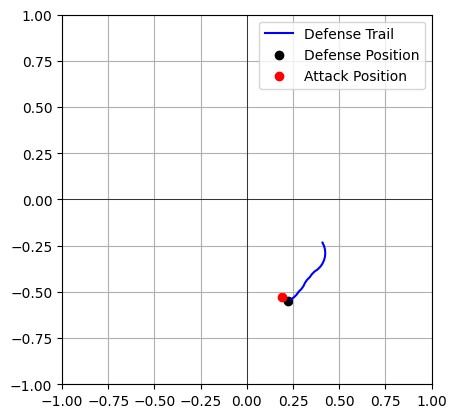

STEP REWARD:  3.0931606481251923
EPISODE REWARD:  3.0931606481251923
STEP REWARD:  3.5501124566613935
EPISODE REWARD:  6.643273104786585
STEP REWARD:  4.003768949517314
EPISODE REWARD:  10.647042054303899
STEP REWARD:  4.519611733852957
EPISODE REWARD:  15.166653788156857
STEP REWARD:  4.843556668748819
EPISODE REWARD:  20.010210456905675
STEP REWARD:  5.450513073980738
EPISODE REWARD:  25.460723530886412
STEP REWARD:  5.934626085986663
EPISODE REWARD:  31.395349616873077
STEP REWARD:  6.871844755792349
EPISODE REWARD:  38.26719437266543
STEP REWARD:  7.669600490547092
EPISODE REWARD:  45.93679486321252
STEP REWARD:  9.300303662310775
EPISODE REWARD:  55.237098525523294
STEP REWARD:  10.842841015294459
EPISODE REWARD:  66.07993954081775
STEP REWARD:  14.346271350663717
EPISODE REWARD:  80.42621089148146
STEP REWARD:  18.418389125431457
EPISODE REWARD:  98.84460001691292
STEP REWARD:  30.65958067683684
EPISODE REWARD:  129.50418069374976
STEP REWARD:  83.86993643908669
EPISODE REWARD:  

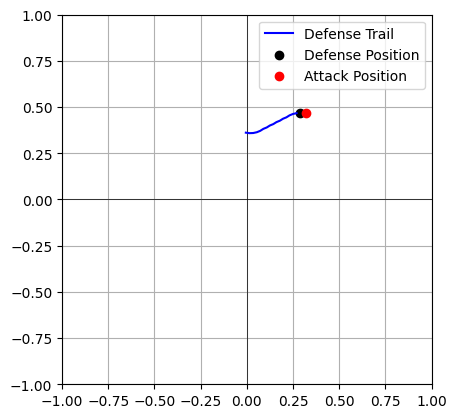

STEP REWARD:  -8.57417360972474
EPISODE REWARD:  -8.57417360972474
STEP REWARD:  -7.95579494475489
EPISODE REWARD:  -16.52996855447963
STEP REWARD:  -7.258857390686976
EPISODE REWARD:  -23.788825945166607
STEP REWARD:  -6.498791132274529
EPISODE REWARD:  -30.287617077441137
STEP REWARD:  -0.1114638647877687
EPISODE REWARD:  -30.399080942228906
STEP REWARD:  0.0534674462231102
EPISODE REWARD:  -30.345613496005797
STEP REWARD:  0.21633337897577493
EPISODE REWARD:  -30.12928011703002
STEP REWARD:  0.37495278816699473
EPISODE REWARD:  -29.754327328863027
STEP REWARD:  0.5268898247031948
EPISODE REWARD:  -29.227437504159834
STEP REWARD:  0.6693562189283448
EPISODE REWARD:  -28.558081285231488
STEP REWARD:  0.7991275748060741
EPISODE REWARD:  -27.758953710425413
STEP REWARD:  0.9124886746477382
EPISODE REWARD:  -26.846465035777676
STEP REWARD:  0.926602520910265
EPISODE REWARD:  -25.91986251486741
STEP REWARD:  1.0222884273763102
EPISODE REWARD:  -24.8975740874911
STEP REWARD:  1.04204476261

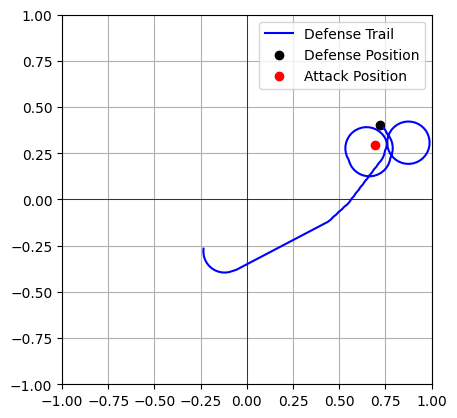

STEP REWARD:  0.20367874117737295
EPISODE REWARD:  0.20367874117737295
STEP REWARD:  0.34061993563184834
EPISODE REWARD:  0.5442986768092213
STEP REWARD:  0.4701206144261584
EPISODE REWARD:  1.0144192912353795
STEP REWARD:  0.5895091282191217
EPISODE REWARD:  1.6039284194545012
STEP REWARD:  0.6958191696249982
EPISODE REWARD:  2.2997475890794994
STEP REWARD:  0.7857917749209724
EPISODE REWARD:  3.085539364000472
STEP REWARD:  0.7972223042631299
EPISODE REWARD:  3.8827616682636017
STEP REWARD:  0.808919005819211
EPISODE REWARD:  4.6916806740828125
STEP REWARD:  0.8208872102542826
EPISODE REWARD:  5.512567884337095
STEP REWARD:  0.8331319507705733
EPISODE REWARD:  6.345699835107668
STEP REWARD:  0.845657877731029
EPISODE REWARD:  7.191357712838697
STEP REWARD:  0.8584691586559681
EPISODE REWARD:  8.049826871494666
STEP REWARD:  0.8715693612687938
EPISODE REWARD:  8.92139623276346
STEP REWARD:  0.8849613169038446
EPISODE REWARD:  9.806357549667304
STEP REWARD:  0.8986469611718028
EPISODE 

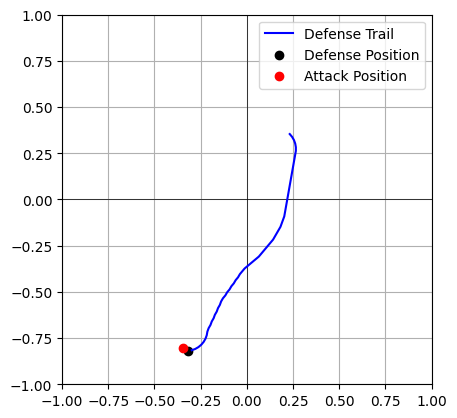

STEP REWARD:  0.14534884795922476
EPISODE REWARD:  0.14534884795922476
STEP REWARD:  0.36067032861495696
EPISODE REWARD:  0.5060191765741817
STEP REWARD:  0.5727179719084616
EPISODE REWARD:  1.0787371484826433
STEP REWARD:  0.779185460192619
EPISODE REWARD:  1.8579226086752625
STEP REWARD:  0.9771029723529808
EPISODE REWARD:  2.835025581028243
STEP REWARD:  1.162602772563977
EPISODE REWARD:  3.99762835359222
STEP REWARD:  1.3306720827886165
EPISODE REWARD:  5.328300436380837
STEP REWARD:  1.4749242680438952
EPISODE REWARD:  6.803224704424732
STEP REWARD:  1.6826453440187774
EPISODE REWARD:  8.485870048443509
STEP REWARD:  1.7332325332372125
EPISODE REWARD:  10.21910258168072
STEP REWARD:  1.6693470661651462
EPISODE REWARD:  11.888449647845867
STEP REWARD:  1.7275473077713568
EPISODE REWARD:  13.615996955617224
STEP REWARD:  1.7898982416988218
EPISODE REWARD:  15.405895197316045
STEP REWARD:  1.8568579085781896
EPISODE REWARD:  17.262753105894234
STEP REWARD:  1.9289539584468949
EPISODE

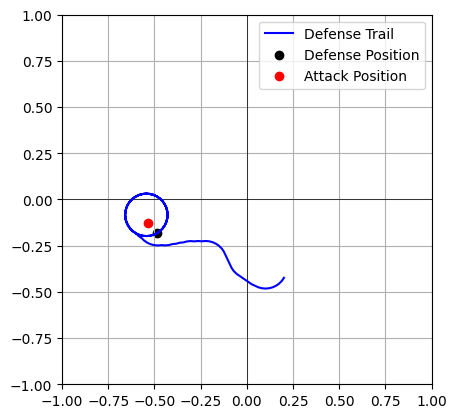

STEP REWARD:  -4.739644278980418
EPISODE REWARD:  -4.739644278980418
STEP REWARD:  -4.347429097884903
EPISODE REWARD:  -9.08707337686532
STEP REWARD:  -3.9010385522936213
EPISODE REWARD:  -12.98811192915894
STEP REWARD:  -3.4087779584454916
EPISODE REWARD:  -16.39688988760443
STEP REWARD:  -2.8778992921203104
EPISODE REWARD:  -19.274789179724742
STEP REWARD:  -2.3150713323845244
EPISODE REWARD:  -21.589860512109265
STEP REWARD:  -1.726692698548312
EPISODE REWARD:  -23.316553210657577
STEP REWARD:  -1.1191031211404492
EPISODE REWARD:  -24.435656331798025
STEP REWARD:  -0.020135379460867603
EPISODE REWARD:  -24.455791711258893
STEP REWARD:  0.36841190957823594
EPISODE REWARD:  -24.087379801680658
STEP REWARD:  0.7649050810208669
EPISODE REWARD:  -23.32247472065979
STEP REWARD:  1.1738133028014799
EPISODE REWARD:  -22.14866141785831
STEP REWARD:  1.5999577865835517
EPISODE REWARD:  -20.54870363127476
STEP REWARD:  2.0485823821883264
EPISODE REWARD:  -18.500121249086433
STEP REWARD:  2.525

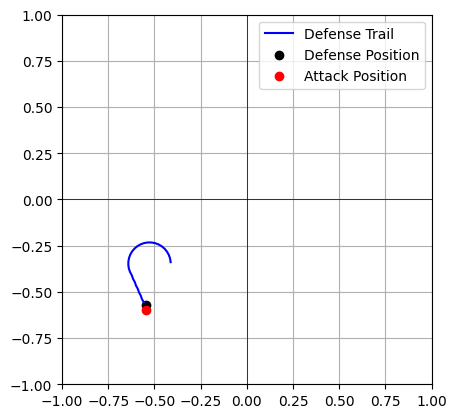

STEP REWARD:  -8.880433711948287
EPISODE REWARD:  -8.880433711948287
STEP REWARD:  -8.911556654694891
EPISODE REWARD:  -17.791990366643176
STEP REWARD:  -8.80142105860374
EPISODE REWARD:  -26.593411425246916
STEP REWARD:  -8.559688723323134
EPISODE REWARD:  -35.15310014857005
STEP REWARD:  -8.19742843240879
EPISODE REWARD:  -43.35052858097884
STEP REWARD:  -7.726713213861965
EPISODE REWARD:  -51.0772417948408
STEP REWARD:  -7.1604148841569435
EPISODE REWARD:  -58.237656678997745
STEP REWARD:  -6.512130800982344
EPISODE REWARD:  -64.74978747998009
STEP REWARD:  -5.7961899712948
EPISODE REWARD:  -70.54597745127488
STEP REWARD:  -5.02769894734074
EPISODE REWARD:  -75.57367639861562
STEP REWARD:  -0.04326144146445682
EPISODE REWARD:  -75.61693784008007
STEP REWARD:  0.13738090824527907
EPISODE REWARD:  -75.4795569318348
STEP REWARD:  0.31549398628579317
EPISODE REWARD:  -75.164062945549
STEP REWARD:  0.48886052372590855
EPISODE REWARD:  -74.6752024218231
STEP REWARD:  0.654909824708376
EPI

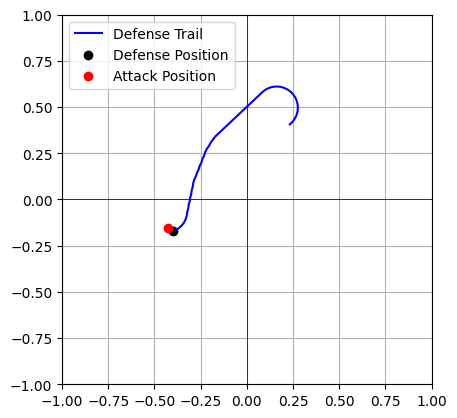

STEP REWARD:  1.4594239669765063
EPISODE REWARD:  1.4594239669765063
STEP REWARD:  1.6067796377348063
EPISODE REWARD:  3.066203604711313
STEP REWARD:  1.8214359716947615
EPISODE REWARD:  4.887639576406074
STEP REWARD:  1.8819535356181878
EPISODE REWARD:  6.769593112024262
STEP REWARD:  1.8195609659035303
EPISODE REWARD:  8.589154077927793
STEP REWARD:  1.8875094018352256
EPISODE REWARD:  10.476663479763019
STEP REWARD:  1.9606314654758337
EPISODE REWARD:  12.437294945238852
STEP REWARD:  1.9350402896475978
EPISODE REWARD:  14.37233523488645
STEP REWARD:  2.0061209244363756
EPISODE REWARD:  16.378456159322823
STEP REWARD:  2.081797896252187
EPISODE REWARD:  18.46025405557501
STEP REWARD:  2.2955207090051686
EPISODE REWARD:  20.755774764580178
STEP REWARD:  2.5623753594741987
EPISODE REWARD:  23.318150124054377
STEP REWARD:  2.5265292189479016
EPISODE REWARD:  25.844679343002277
STEP REWARD:  2.8261498656813338
EPISODE REWARD:  28.67082920868361
STEP REWARD:  2.8086328879710782
EPISODE R

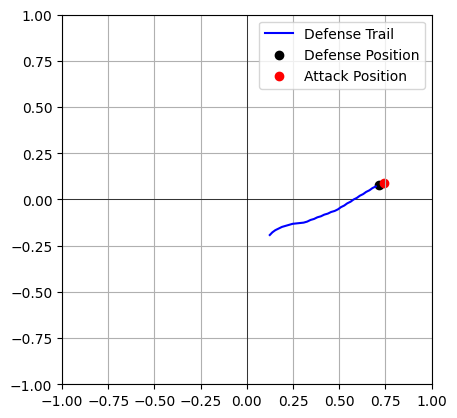

STEP REWARD:  0.8435015897607516
EPISODE REWARD:  0.8435015897607516
STEP REWARD:  1.0567226267612602
EPISODE REWARD:  1.9002242165220118
STEP REWARD:  1.25817335364284
EPISODE REWARD:  3.158397570164852
STEP REWARD:  1.4425937206238637
EPISODE REWARD:  4.600991290788716
STEP REWARD:  1.4775008360196078
EPISODE REWARD:  6.0784921268083245
STEP REWARD:  1.5134146264179682
EPISODE REWARD:  7.591906753226293
STEP REWARD:  1.550281095343504
EPISODE REWARD:  9.142187848569797
STEP REWARD:  1.5880181943539675
EPISODE REWARD:  10.730206042923765
STEP REWARD:  1.6265082541899325
EPISODE REWARD:  12.356714297113697
STEP REWARD:  1.6655885981258727
EPISODE REWARD:  14.02230289523957
STEP REWARD:  1.7050399493025703
EPISODE REWARD:  15.72734284454214
STEP REWARD:  1.7445721891856831
EPISODE REWARD:  17.47191503372782
STEP REWARD:  1.9933727711610265
EPISODE REWARD:  19.46528780488885
STEP REWARD:  2.3205434153152287
EPISODE REWARD:  21.785831220204077
STEP REWARD:  2.490884539283234
EPISODE REWAR

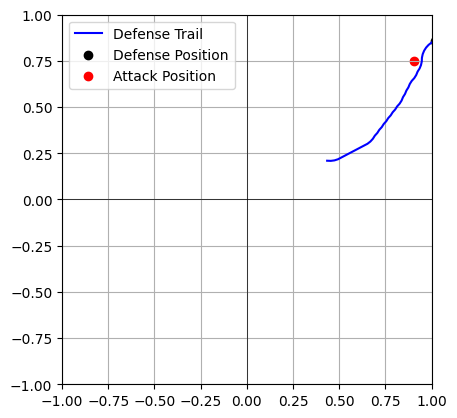

STEP REWARD:  -7.251746174115557
EPISODE REWARD:  -7.251746174115557
STEP REWARD:  -7.099839470775914
EPISODE REWARD:  -14.351585644891472
STEP REWARD:  -6.825766257716787
EPISODE REWARD:  -21.177351902608258
STEP REWARD:  -6.442324226880932
EPISODE REWARD:  -27.61967612948919
STEP REWARD:  -5.962322684896192
EPISODE REWARD:  -33.58199881438538
STEP REWARD:  -5.398534843065434
EPISODE REWARD:  -38.98053365745081
STEP REWARD:  -4.763771220991844
EPISODE REWARD:  -43.744304878442655
STEP REWARD:  -4.0710109551453435
EPISODE REWARD:  -47.815315833588
STEP REWARD:  -3.3335521437708966
EPISODE REWARD:  -51.1488679773589
STEP REWARD:  -0.060998608365072704
EPISODE REWARD:  -51.20986658572397
STEP REWARD:  0.16046789444300646
EPISODE REWARD:  -51.04939869128096
STEP REWARD:  0.3807334405164933
EPISODE REWARD:  -50.66866525076447
STEP REWARD:  0.5980279395230427
EPISODE REWARD:  -50.07063731124143
STEP REWARD:  0.8101269391042453
EPISODE REWARD:  -49.26051037213718
STEP REWARD:  1.014131508146

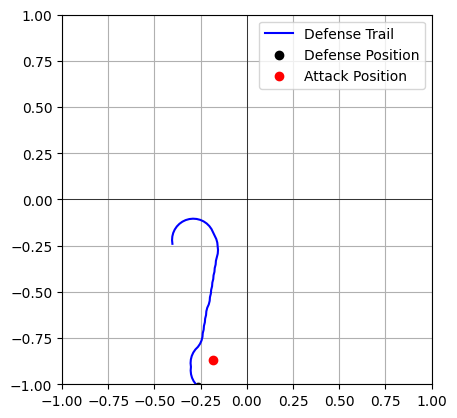

Average Reward: 460.3389160854293
Average Episode Length: 64.0
All Episodes Data:  {'Episode 1': {'past_defense_positions': [array([ 0.4090957, -0.2333751]), array([ 0.41744204, -0.25155031]), array([ 0.4225055 , -0.27089874]), array([ 0.4241322 , -0.29083247]), array([ 0.42227274, -0.31074584]), array([ 0.41698361, -0.3300338 ]), array([ 0.40842551, -0.34811027]), array([ 0.39685849, -0.36442603]), array([ 0.38263399, -0.37848532]), array([ 0.36618422, -0.38986095]), array([ 0.35195972, -0.40392024]), array([ 0.34039269, -0.420236  ]), array([ 0.32616819, -0.43429529]), array([ 0.31460116, -0.45061104]), array([ 0.30604307, -0.46868752]), array([ 0.29447604, -0.48500328]), array([ 0.28025154, -0.49906256]), array([ 0.26868451, -0.51537832]), array([ 0.25446001, -0.52943761]), array([ 0.23801025, -0.54081325])], 'attack_positions': [array([ 0.19037759, -0.53002453]), array([ 0.19037759, -0.53002453]), array([ 0.19037759, -0.53002453]), array([ 0.19037759, -0.53002453]), array([ 0.19037

In [2]:
import time
from copy import deepcopy  # Import deepcopy

model = DQN.load("dqn_missile_interception")


eval_env = missile_interception()

def graph(defense_positions, defense, attack):
    print("Plotting data:", defense_positions, defense, attack)  # Debug output
    fig, ax = plt.subplots()
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.grid(True)

    defense_xs, defense_ys = zip(*defense_positions)
    ax.plot(defense_xs, defense_ys, 'b-', label='Defense Trail')  
    ax.scatter(defense[0], defense[1], color='black', label='Defense Position')
    ax.scatter(attack[0], attack[1], color='red', label='Attack Position')

    ax.set_aspect('equal')
    ax.legend()
    plt.show()

def just_trails(defense_positions):
    fig, ax = plt.subplots()
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.grid(True)

    if len(defense_positions) > 1:
        print("FUCKING TRUE")
        # Extracting x and y coordinates
        defense_xs, defense_ys = zip(*defense_positions)
        print("DEFENSE XS: ", defense_xs)
        print("DEFENSE YS: ", defense_ys)
        print("length defense xs:", len(defense_xs))
        print("length defense ys:", len(defense_ys))
        ax.scatter(defense_xs, defense_ys, color='black', label='Defense Trail')  # Black dots for defense trail
        ax.plot(defense_xs, defense_ys, 'b-', linewidth=2, label='Defense Trail')  # Blue line for defense trail

    ax.set_aspect('equal')
    ax.legend()
    plt.show()

# Function to plot the trail
def plot_defense_trail(defense_positions):
    fig, ax = plt.subplots()
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.grid(True)

    # Extracting x and y coordinates
    defense_xs, defense_ys = zip(*defense_positions)

    # turn into np.array
    defense_xs = np.array(defense_xs)
    defense_ys = np.array(defense_ys)

    print("defense_xs: ", defense_xs)
    print("defense_ys: ", defense_ys)

    # Plotting the trail
    ax.plot(defense_xs, defense_ys, 'b-', label='Defense Trail')  # Blue line for defense trail
    ax.scatter(defense_xs[-1], defense_ys[-1], color='red', s=100, label='Current Position')  # Current position

    ax.set_aspect('equal')
    ax.legend()
    plt.show()

# Number of evaluation episodes
n_eval_episodes = 10

# Lists to store results
episode_rewards = []
episode_lengths = []
interceptions = 0
out_of_bounds = 0
reached_max_steps = 0

all_episodes_data = {}

for i in range(n_eval_episodes):
    episode_data = {
        'past_defense_positions': [],
        'attack_positions': [],
        'defense_positions': [],
        'times': []
    }

    obs, _ = eval_env.reset()
    done = False
    episode_reward = 0
    episode_length = 0
    time_step = 0
    defense_positions = []  # Store defense positions for plotting

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        defense_positions.append(deepcopy(eval_env.defense))
        episode_data['past_defense_positions'].append(deepcopy(eval_env.defense))          
        obs, reward, done, _, info = eval_env.step(action)
        episode_data['defense_positions'].append(deepcopy(eval_env.defense))
        episode_data['attack_positions'].append(deepcopy(eval_env.attack))
        episode_data['times'].append(time_step * 0.02)

        episode_reward += reward
        print("STEP REWARD: ", reward)
        print("EPISODE REWARD: ", episode_reward)
        episode_length += 1

        # Update stats based on info dictionary if needed
        # interceptions += info.get('interceptions', 0)
        # out_of_bounds += info.get('out_of_bounds', 0)
        # reached_max_steps += info.get('reached_max_steps', 0)

        # Graph current and trail positions
        # graph(defense_positions, eval_env.defense, eval_env.attack)
        # just_trails(defense_positions)
        time_step += 1

    episode_key = f"Episode {i + 1}"  # Adding 1 to make it human-readable (1-indexed)
    all_episodes_data[episode_key] = episode_data

    # Store results
    graph(defense_positions, eval_env.defense, eval_env.attack)
    # just_trails(defense_positions)
    episode_rewards.append(episode_reward)
    episode_lengths.append(episode_length)

    # plot_defense_trail(defense_positions)

# Output averaged results or other statistics
print(f"Average Reward: {sum(episode_rewards) / len(episode_rewards)}")
print(f"Average Episode Length: {sum(episode_lengths) / len(episode_lengths)}")

print("All Episodes Data: ", all_episodes_data)

# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation

# def create_animation(episode_data, episode_index):
#     fig, ax = plt.subplots()
#     plt.xlim(-10, 10)
#     plt.ylim(-10, 10)
#     ax.set_aspect(1)
#     plt.grid(True)

#     defense_line, = ax.plot([], [], 'b-', label='Defense Trail')
#     attack_line, = ax.plot([], [], 'r-', label='Attack Trail')
#     defense_point, = ax.plot([], [], 'bo', label='Current Defense')
#     attack_point, = ax.plot([], [], 'ro', label='Current Attack')

#     def init():
#         defense_line.set_data([], [])
#         attack_line.set_data([], [])
#         defense_point.set_data([], [])
#         attack_point.set_data([], [])
#         return defense_line, attack_line, defense_point, attack_point

#     def update(frame):
#         defense_line.set_data(episode_data['defense_positions'][:frame], episode_data['times'][:frame])
#         attack_line.set_data(episode_data['attack_positions'][:frame], episode_data['times'][:frame])
        
#         defense_point.set_data(episode_data['defense_positions'][frame], episode_data['times'][frame])
#         attack_point.set_data(episode_data['attack_positions'][frame], episode_data['times'][frame])
        
#         return defense_line, attack_line, defense_point, attack_point

#     ani = FuncAnimation(fig, update, frames=len(episode_data['times']), init_func=init, blit=True, repeat=False)
#     plt.legend()

#     # Save or display the animation
#     ani.save(f"episode_{episode_index}.mp4", writer='ffmpeg')  # Save as video
#     # plt.show()  # Or display it interactively



    


# def graph(trajectory_data):
#     fig, ax = plt.subplots()
#     plt.xlim(-1, 1)
#     plt.ylim(-1, 1)
#     plt.axhline(0, color='black', linewidth=0.5)
#     plt.axvline(0, color='black', linewidth=0.5)
#     plt.grid(True)

#     # Plot trajectories
#     for trail in trajectory_data:
#         defense_xs, defense_ys = zip(*trail['defense_positions'])
#         attack_xs, attack_ys = zip(*trail['attack_positions'])
#         ax.plot(defense_xs, defense_ys, 'b-')  # Blue line for defense
#         ax.plot(attack_xs, attack_ys, 'r-')  # Red line for attack
#         plt.scatter(defense_xs[-1], defense_ys[-1], color='black')  # Current defense position
#         plt.scatter(attack_xs[-1], attack_ys[-1], color='red')  # Current attack position

#     plt.show()

# for i in range(n_eval_episodes):
#     obs, _ = eval_env.reset()
#     done = False
#     episode_reward = 0
#     episode_length = 0
#     trajectories = {'defense_positions': [], 'attack_positions': []}  # Store trajectories
    
#     while not done:
#         action, _ = model.predict(obs, deterministic=True)
#         obs, reward, done, _, info = eval_env.step(action)
#         env.graph(eval_env.defense, eval_env.attack)
#         trajectories['defense_positions'].append(tuple(eval_env.defense))
#         trajectories['attack_positions'].append(tuple(eval_env.attack))
#         episode_reward += reward
#         episode_length += 1
        
    
#     episode_rewards.append(episode_reward)
#     episode_lengths.append(episode_length)
#     interceptions += eval_env.interceptions
#     out_of_bounds += eval_env.out_of_bounds
#     reached_max_steps += eval_env.reached_max_steps
#     graph(trajectories)

# # Calculate average metrics
# avg_reward = np.mean(episode_rewards)
# avg_length = np.mean(episode_lengths)
# success_rate = interceptions / n_eval_episodes
# out_of_bounds_rate = out_of_bounds / n_eval_episodes
# max_steps_rate = reached_max_steps / n_eval_episodes

# print(f"Average Reward: {avg_reward:.2f}")
# print(f"Average Episode Length: {avg_length:.2f}")
# print(f"Success Rate: {success_rate:.2%}")
# print(f"Out of Bounds Rate: {out_of_bounds_rate:.2%}")
# print(f"Reached Max Steps Rate: {max_steps_rate:.2%}")

In [65]:
print("All Episodes Data: ", all_episodes_data)
print(type(all_episodes_data))

# 

All Episodes Data:  {'Episode 1': {'past_defense_positions': [array([ 0.30016461, -0.11128399]), array([ 0.30792881, -0.09285257]), array([ 0.31569302, -0.07442116]), array([ 0.32345722, -0.05598974]), array([ 0.33122143, -0.03755832]), array([ 0.33898563, -0.01912691]), array([ 0.34674984, -0.00069549]), array([0.35451404, 0.01773593]), array([0.36227825, 0.03616735]), array([0.37004245, 0.05459876]), array([0.37780665, 0.07303018]), array([0.38557086, 0.0914616 ]), array([0.39641769, 0.10826476]), array([0.40726452, 0.12506792]), array([0.4208644 , 0.13973227]), array([0.43680411, 0.15181225]), array([0.45274382, 0.16389222]), array([0.47053903, 0.17302077]), array([0.48833424, 0.18214932]), array([0.50612945, 0.19127787]), array([0.52392467, 0.20040642]), array([0.54303468, 0.20630618]), array([0.5621447 , 0.21220594]), array([0.57993992, 0.22133449]), array([0.59773513, 0.23046304]), array([0.61367483, 0.24254301]), array([0.63147005, 0.25167156]), array([0.64740975, 0.26375153]), 

In [ ]:
# import gymnasium as gym
# from stable_baselines3 import DQN, PPO
# from stable_baselines3.common.vec_env import DummyVecEnv
# env = DummyVecEnv([lambda: missile_interception()])

# summary_writer = tf.summary.create_file_writer('./dqn_missile_interception_logs')

# def run_episode(env):
#     with summary_writer.as_default():
#         for step in range(env.max_steps):
#             ...
#             tf.summary.scalar('Reward', reward, step=total_steps)
#             if done:
#                 tf.summary.scalar('Episode Length', step + 1, step=episode)
#                 break
#         tf.summary.scalar('Out of Bounds Count', env.out_of_bounds, step=episode)
#         tf.summary.scalar('Interceptions Count', env.interceptions, step=episode)
#         tf.summary.scalar('Reached Max Steps Count', env.reached_max_steps, step=episode)

# model = DQN("MlpPolicy", env, tensorboard_log="./dqn_missile_interception_logs", verbose=1)
# model.learn(total_timesteps=1000000)
# model.save("updated_missile_guidance")
# env.close()

In [ ]:
# # import gymnasium as gym
# import numpy as np
# import matplotlib.pyplot as plt
# import random
# import math
# import tensorflow as tf
# import datetime

# # Assuming missile_interception is already defined and imported

# def run_episodes(num_episodes, max_steps_per_episode):
#     # Initialize variables for tracking statistics
#     episode_lengths = []
#     hits = 0  # Track the number of successful hits

#     # Run multiple episodes
#     for episode in range(num_episodes):
#         # Reset the environment at the start of each episode
#         env = missile_interception()
#         _, _ = env.reset()
        
#         print("----------------------------------------------------------")
#         print(f"STARTING EPISODE {episode + 1}")
#         print("----------------------------------------------------------")
        
#         # Run the simulation for up to max_steps_per_episode or until the episode ends
#         for step in range(max_steps_per_episode):
#             # Choose a random action
#             action = random.choice([0, 1, 2])
#             # actions = [random.choice([0, 1, 2]) for _ in range(num_steps)]
            
#             # Take the action and observe the outcome
#             state, reward, done, truncated, _ = env.step(action)

#             # Check if a hit has occurred, typically by checking reward or state
#             if reward > 90:  # Assuming reward > 90 indicates a hit
#                 hits += 1
#                 print(f"Hit! Missile successfully intercepted the target at step {step + 1} of episode {episode + 1}.")

#             if done:
#                 # If the episode has ended, record the length
#                 episode_lengths.append(step + 1)
#                 print(f"Episode {episode + 1} ended after {step + 1} steps.")
#                 break
#         else:
#             # If not done after max steps, consider it a full length episode
#             episode_lengths.append(max_steps_per_episode)
    
#     # Calculate the average episode length
#     average_length = np.mean(episode_lengths)
#     return average_length, episode_lengths, hits

# # Parameters
# num_episodes = 100
# max_steps_per_episode = 150

# # Run the simulations
# average_length, episode_lengths, total_hits = run_episodes(num_episodes, max_steps_per_episode)

# print("----------------------------------------------------------")
# print(f"Average episode length over {num_episodes} episodes: {average_length:.2f} steps")
# print(f"Total hits across all episodes: {total_hits}")
# print("----------------------------------------------------------")


In [4]:
import gymnasium as gym 
from gymnasium import Env
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import tensorflow as tf
import datetime
import gymnasium as gym
import numpy as np
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env
import tensorflow as tf

# # Set seed for reproducibility
# seed = 42
# random.seed(seed)
# np.random.seed(seed)

class missile_interception(Env):
    def __init__(self):
        self.action_space = gym.spaces.discrete.Discrete(3)
        low = np.array([-1, -1, -1, -1, -1, -1, -1, -1, -2, -2, -0.04, -2.828, -70.71], dtype=np.float32)
        high = np.array([1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2.828, 2.828, 70.71], dtype=np.float32)

        self.observation_space = gym.spaces.Box(low=low, high=high, dtype=np.float32)
        self.radius = 0.02

        self.episode_count = 0
        self.distance_t_minus_one = 0
        self.distance_change = 0

        self.out_of_bounds = 0
        self.interceptions = 0
        self.reached_max_steps = 0

        self.defense_positions = []
        self.attack_positions = []

        self.max_steps_per_episode = 150

    def reset(self, seed=None):
        self.defense_positions = []
        self.attack_positions = []
        self.reward = 0
        self.current_step = 0
        self.done = False
        self.create_defense()
        self.create_attack(self.defense)
        self.calc_angle(self.defense, self.attack)
        self.initial_missile_angle()
        self.missile_distance_to_attack()
        # self.graph(self.defense, self.attack)
        self.get_state()

        return self.state, {}

    def create_defense(self):
        x = random.uniform(-0.45, 0.45)
        y = random.uniform(-0.45, 0.45)
        self.defense = np.array([x, y])

    def create_attack(self, defense):
        x_side_left = random.uniform(-0.95, (defense[0] - 0.02) - 0.1)
        x_side_right = random.uniform((defense[0] + 0.02) + 0.1, 0.95)
        y_below = random.uniform((defense[1] - 0.02) - 0.1, -0.95)
        y_above = random.uniform((defense[1] + 0.02) + 0.1, 0.95)
        x_inclusive = random.uniform(-0.95, 0.95)
        y_inclusive = random.uniform(-0.95, 0.95)
        y_below_x_inclusive = np.array([x_inclusive, y_below])
        y_above_x_inclusive = np.array([x_inclusive, y_above])
        x_left_y_inclusive = np.array([x_side_left, y_inclusive])
        x_right_y_inclusive = np.array([x_side_right, y_inclusive])

        self.attack = random.choice([y_below_x_inclusive, y_above_x_inclusive, x_left_y_inclusive, x_right_y_inclusive])

    def calc_angle(self, defense, attack):

        # create an adjacent point of the form (attack_x, defense_y)
        adjacent_point = np.array([attack[0], defense[1]])

        # calculate the distance between the adjacent point and the defense, attack points
        adj_point_defense_len = abs(defense[0] - adjacent_point[0]) 
        adj_point_attack_len = abs(attack[1] - adjacent_point[1])

        # calculate the angle, using soh cah toa, where adj_point_defense_len is the adjacent side and adj_point_attack_len is the opposite side
        self.theta = np.arctan(adj_point_attack_len / adj_point_defense_len)
        
        if attack[0] > defense[0]:
            if attack[1] > defense[1]:
                self.theta = self.theta # 1st quadrant
            else: 
                self.theta = (2*math.pi) - self.theta # 360 - theta
        else:
            if attack[1] > defense[1]:
                self.theta = math.pi - self.theta # 180 - theta
            else:
                self.theta = math.pi + self.theta # 180 + theta
            
        return self.theta
    
    def initial_missile_angle(self):
        self.missile_angle = np.random.uniform(0, 2*math.pi)
        # if self.theta < math.pi:
        #     self.missile_angle = np.random.uniform(0, math.pi)
        # else:
        #     self.missile_angle = np.random.uniform(math.pi, 2*math.pi)

    def calculate_distance(self, point1, point2):
        return math.hypot(point1[0] - point2[0], point1[1] - point2[1])
    
    def missile_distance_to_attack(self):
        self.distance = (self.calculate_distance(self.defense, self.attack) - (2 * self.radius))

    def missile_nav_angle(self, action):
        if action == 0:
            self.missile_angle = self.missile_angle 
        elif action == 1:
            self.missile_angle += 0.174532925
        elif action == 2:
            self.missile_angle -= 0.174532925

    def missle_coord_calc(self):
        self.defense[0] += (0.02 * math.cos(self.missile_angle)) # gotta test this
        self.defense[1] += (0.02 * math.sin(self.missile_angle))

        self.defense_positions.append(self.defense.copy())
        self.attack_positions.append(self.attack.copy())

    def calculate_reward(self):
        self.missile_distance_to_attack()

        if self.distance < 0:
            self.reward = 1000
            self.done = True
            self.interceptions += 1
        else:
            self.distance_change = ((self.distance - self.distance_t_minus_one) / 0.02) 
            if self.distance_change < 0:
                self.reward = -1 * (self.distance_change * (0.01 + 1/self.distance))
            else:
                self.reward = -8 * (self.distance_change * 1 + 1 * (self.distance**2))

            # angle penalty
            self.angle_diff = abs(self.theta - self.missile_angle)
            self.angle_diff = min(self.angle_diff, 2*math.pi - self.angle_diff)
            if self.angle_diff < 0.05:
                try:
                    if 1/self.angle_diff < 100:
                        reward += 1/self.angle_diff
                    else:
                        reward += 100
                except ZeroDivisionError:
                    reward += 100
            else:
                self.reward -= (2 * self.angle_diff)
            
            # time penalty
            self.reward -= 0.1 * self.current_step
                
        if self.defense[0] < -1 or self.defense[0] > 1 or self.defense[1] < -1 or self.defense[1] > 1:
            print("OUT OF BOUNDS")
            self.reward = -1000
            self.done = True
            self.out_of_bounds += 1

    def angle_conversion(self):
        self.sin_theta, self.sin_missile_angle = np.sin(self.theta), np.sin(self.missile_angle)
        self.cos_theta, self.cos_missile_angle = np.cos(self.theta), np.cos(self.missile_angle)

        self.delta_sin = self.sin_theta - self.sin_missile_angle
        self.delta_cos = self.cos_theta - self.cos_missile_angle

    def get_state(self):
        self.angle_conversion()
        self.state = np.array([self.attack[0], self.attack[1], self.defense[0], self.defense[1], self.sin_theta, self.cos_theta, self.sin_missile_angle, self.cos_missile_angle, self.delta_sin, self.delta_cos, self.distance, (self.distance - self.distance_t_minus_one), ((self.distance - self.distance_t_minus_one) / 0.02)], self.current_step, (-0.1 * self.current_step), self.angle_diff)

    def get_state_dict(self):
        return {"reward": self.reward, "attack_x": self.attack[0], "attack_y": self.attack[1], "defense_x": self.defense[0], "defense_y": self.defense[1], "theta": self.theta, "missile_angle": self.missile_angle, "self.sin_theta": self.sin_theta, "self.cos_theta": self.cos_theta, "self.sin_missile_angle": self.sin_missile_angle, "self.cos_missile_angle": self.cos_missile_angle, "delta_sin": self.delta_sin, "delta_cos": self.delta_cos, "distance": self.distance, "current_step": self.current_step}
                 
    def step(self, action):
        self.distance_t_minus_one = self.distance
        self.missile_nav_angle(action)
        self.missle_coord_calc()
        self.calculate_reward()
        self.current_step += 1

        if self.current_step >= self.max_steps_per_episode:
            self.done = True
            self.reward = -1000
            self.reached_max_steps += 1

        self.get_state()

        # self.graph(self.defense, self.attack)

        return self.state, self.reward, self.done, False, {}

    def graph(self, defense, attack):
        fig, ax = plt.subplots()
        plt.xlim(-1, 1)
        plt.ylim(-1, 1)

        plt.axhline(0, color='black', linewidth=0.5)
        plt.axvline(0, color='black', linewidth=0.5)
        plt.grid(True)

        # Plot trails
        if self.defense_positions:
            defense_xs, defense_ys = zip(*self.defense_positions)
            ax.plot(defense_xs, defense_ys, 'b-')  # Blue line for defense

        if self.attack_positions:
            attack_xs, attack_ys = zip(*self.attack_positions)
            ax.plot(attack_xs, attack_ys, 'r-')  # Red line for attack

        # Plot current positions
        plt.scatter(defense[0], defense[1], color='black')
        plt.scatter(attack[0], attack[1], color='red')

        ax.set_aspect('equal')
        plt.show()

In [7]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import HTML, display


def animate_episode(episode_data, save_name):
    episode_past_defense_positions = episode_data["past_defense_positions"]
    past_defense_x, past_defense_y = zip(*episode_past_defense_positions)
    episode_attack_positions = episode_data["attack_positions"]
    attack_x, attack_y = zip(*episode_attack_positions)
    episode_defense_positions = episode_data["defense_positions"]
    defense_x, defense_y = zip(*episode_defense_positions)

    # Create figure and axis
    fig, ax = plt.subplots()
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.grid(True)

    trail, = ax.plot([], [], 'b-', label='Defense Trail')  
    scatter1, = ax.plot([], [], 'ro')  # 'ro' means red circles
    scatter2, = ax.plot([], [], 'bo')  # 'ro' means red circles

    # Update function for animation
    def update(frame):
        trail.set_data(past_defense_x[:frame+1], past_defense_y[:frame+1])
        scatter1.set_data(attack_x[frame], attack_y[frame])
        scatter2.set_data(defense_x[frame], defense_y[frame])
        return trail, scatter1, scatter2

    # Create animation
    ani = animation.FuncAnimation(fig, update, frames=len(past_defense_x), interval=200, blit=True)

    # Option 1: Save animation
    ani.save(save_name, writer='pillow')
    print(f"Animation saved as {save_name}")

    # # Option 2: Display using HTML
    # plt.close(fig)
    # video = ani.to_html5_video()
    # html = display(HTML(video))

    plt.show()

Using cpu device
Logging to ./dqn_missile_guidance_local_v2\DQN_0
OUT OF BOUNDS
OUT OF BOUNDS
OUT OF BOUNDS
OUT OF BOUNDS
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 64.2      |
|    ep_rew_mean      | -1.16e+03 |
|    exploration_rate | 0.976     |
| time/               |           |
|    episodes         | 4         |
|    fps              | 1687      |
|    time_elapsed     | 0         |
|    total_timesteps  | 257       |
| train/              |           |
|    learning_rate    | 0.0001    |
|    loss             | 34.6      |
|    n_updates        | 39        |
-----------------------------------
OUT OF BOUNDS
OUT OF BOUNDS
OUT OF BOUNDS
OUT OF BOUNDS
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 76.4      |
|    ep_rew_mean      | -1.59e+03 |
|    exploration_rate | 0.942     |
| time/               |           |
|    episodes         | 8         |
|    fps              | 1508  

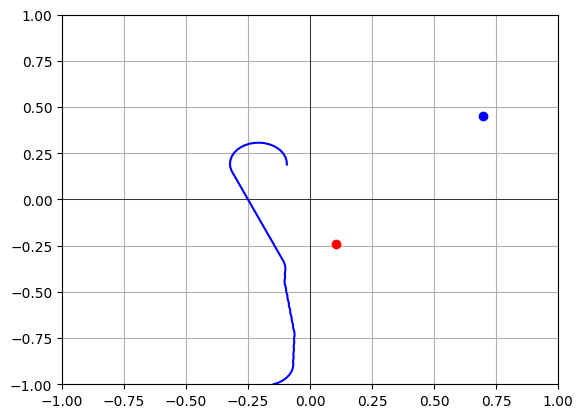

c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.out_of_bounds to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.out_of_bounds` for environment variables or `env.get_wrapper_attr('out_of_bounds')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.interceptions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.interceptions` for environment variables or `env.get_wrapper_attr('interceptions')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.reached_max_steps to get variables from other wrappers is deprecated and will be 

Logging to ./dqn_missile_guidance_local_v2\DQN_0
OUT OF BOUNDS
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 84.9     |
|    ep_rew_mean      | -501     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1124     |
|    fps              | 992      |
|    time_elapsed     | 0        |
|    total_timesteps  | 100531   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 35.1     |
|    n_updates        | 25107    |
----------------------------------
OUT OF BOUNDS
OUT OF BOUNDS
OUT OF BOUNDS
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 84.7     |
|    ep_rew_mean      | -473     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1128     |
|    fps              | 1045     |
|    time_elapsed     | 0        |
|    total_timesteps  | 100809   |
| train/            

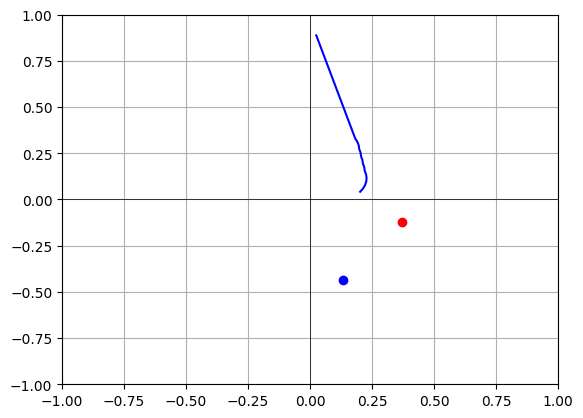

Logging to ./dqn_missile_guidance_local_v2\DQN_0


c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.out_of_bounds to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.out_of_bounds` for environment variables or `env.get_wrapper_attr('out_of_bounds')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.interceptions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.interceptions` for environment variables or `env.get_wrapper_attr('interceptions')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.reached_max_steps to get variables from other wrappers is deprecated and will be 

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | 222      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2120     |
|    fps              | 131      |
|    time_elapsed     | 0        |
|    total_timesteps  | 200020   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.5      |
|    n_updates        | 49979    |
----------------------------------
OUT OF BOUNDS
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | 233      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2124     |
|    fps              | 496      |
|    time_elapsed     | 1        |
|    total_timesteps  | 200530   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.03     |
|    n

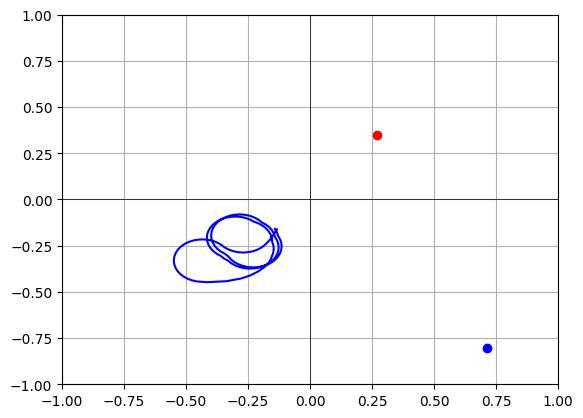

Logging to ./dqn_missile_guidance_local_v2\DQN_0


c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.out_of_bounds to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.out_of_bounds` for environment variables or `env.get_wrapper_attr('out_of_bounds')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.interceptions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.interceptions` for environment variables or `env.get_wrapper_attr('interceptions')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.reached_max_steps to get variables from other wrappers is deprecated and will be 

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 81.3     |
|    ep_rew_mean      | 809      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3252     |
|    fps              | 439      |
|    time_elapsed     | 0        |
|    total_timesteps  | 300112   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.38     |
|    n_updates        | 75002    |
----------------------------------
OUT OF BOUNDS
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 82.8     |
|    ep_rew_mean      | 767      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3256     |
|    fps              | 825      |
|    time_elapsed     | 0        |
|    total_timesteps  | 300546   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.39     |
|    n

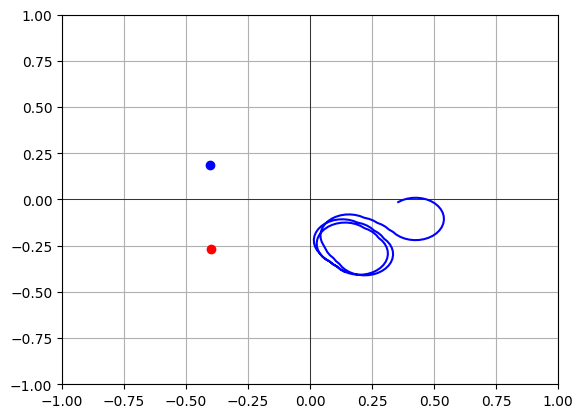

Logging to ./dqn_missile_guidance_local_v2\DQN_0


c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.out_of_bounds to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.out_of_bounds` for environment variables or `env.get_wrapper_attr('out_of_bounds')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.interceptions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.interceptions` for environment variables or `env.get_wrapper_attr('interceptions')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.reached_max_steps to get variables from other wrappers is deprecated and will be 

OUT OF BOUNDS
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 91.2     |
|    ep_rew_mean      | 497      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4484     |
|    fps              | 708      |
|    time_elapsed     | 0        |
|    total_timesteps  | 400225   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 30.4     |
|    n_updates        | 100031   |
----------------------------------
OUT OF BOUNDS
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 91.4     |
|    ep_rew_mean      | 513      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4488     |
|    fps              | 847      |
|    time_elapsed     | 0        |
|    total_timesteps  | 400496   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.7

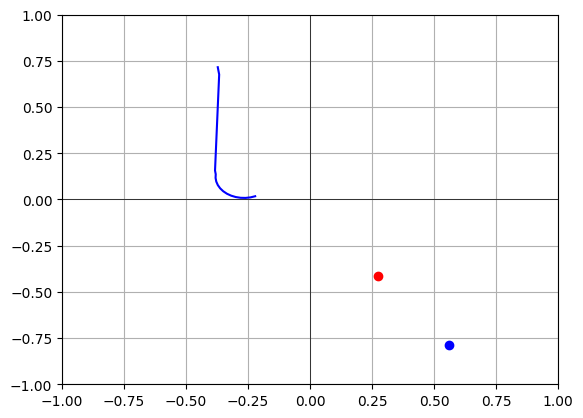

Logging to ./dqn_missile_guidance_local_v2\DQN_0


c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.out_of_bounds to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.out_of_bounds` for environment variables or `env.get_wrapper_attr('out_of_bounds')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.interceptions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.interceptions` for environment variables or `env.get_wrapper_attr('interceptions')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.reached_max_steps to get variables from other wrappers is deprecated and will be 

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 70       |
|    ep_rew_mean      | 938      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5752     |
|    fps              | 506      |
|    time_elapsed     | 0        |
|    total_timesteps  | 500205   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.75     |
|    n_updates        | 125026   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 69.1     |
|    ep_rew_mean      | 970      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5756     |
|    fps              | 706      |
|    time_elapsed     | 0        |
|    total_timesteps  | 500503   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 14.4     |
|    n_updates      

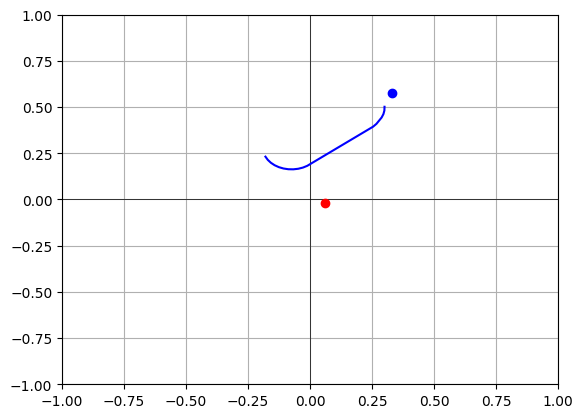

Logging to ./dqn_missile_guidance_local_v2\DQN_0


c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.out_of_bounds to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.out_of_bounds` for environment variables or `env.get_wrapper_attr('out_of_bounds')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.interceptions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.interceptions` for environment variables or `env.get_wrapper_attr('interceptions')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.reached_max_steps to get variables from other wrappers is deprecated and will be 

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 74.3     |
|    ep_rew_mean      | 897      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7272     |
|    fps              | 640      |
|    time_elapsed     | 0        |
|    total_timesteps  | 600127   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.02     |
|    n_updates        | 150006   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 75.5     |
|    ep_rew_mean      | 910      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7276     |
|    fps              | 927      |
|    time_elapsed     | 0        |
|    total_timesteps  | 600490   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 8.84     |
|    n_updates      

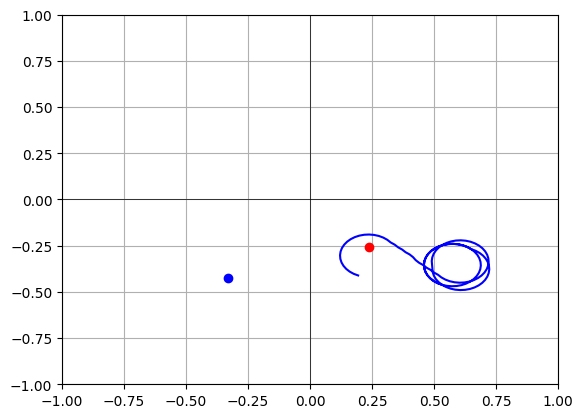

c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.out_of_bounds to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.out_of_bounds` for environment variables or `env.get_wrapper_attr('out_of_bounds')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.interceptions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.interceptions` for environment variables or `env.get_wrapper_attr('interceptions')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.reached_max_steps to get variables from other wrappers is deprecated and will be 

Logging to ./dqn_missile_guidance_local_v2\DQN_0
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 83.6     |
|    ep_rew_mean      | 480      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8452     |
|    fps              | 626      |
|    time_elapsed     | 0        |
|    total_timesteps  | 700451   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 31.7     |
|    n_updates        | 175087   |
----------------------------------
OUT OF BOUNDS
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 84.8     |
|    ep_rew_mean      | 482      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8456     |
|    fps              | 758      |
|    time_elapsed     | 1        |
|    total_timesteps  | 700848   |
| train/              |          |
|    learning_rate    | 0.0

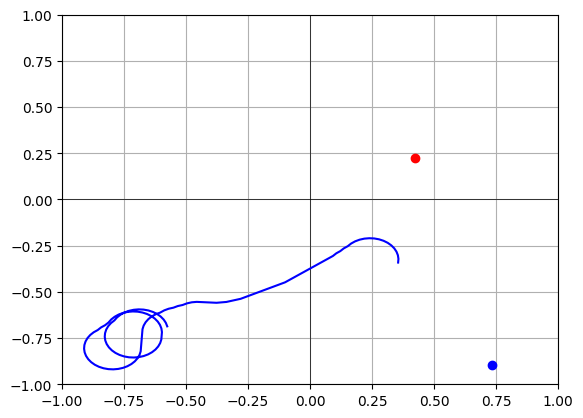

c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.out_of_bounds to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.out_of_bounds` for environment variables or `env.get_wrapper_attr('out_of_bounds')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.interceptions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.interceptions` for environment variables or `env.get_wrapper_attr('interceptions')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.reached_max_steps to get variables from other wrappers is deprecated and will be 

Logging to ./dqn_missile_guidance_local_v2\DQN_0
OUT OF BOUNDS
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80.9     |
|    ep_rew_mean      | 524      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9652     |
|    fps              | 240      |
|    time_elapsed     | 0        |
|    total_timesteps  | 800076   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.07     |
|    n_updates        | 199993   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80.6     |
|    ep_rew_mean      | 562      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9656     |
|    fps              | 551      |
|    time_elapsed     | 0        |
|    total_timesteps  | 800348   |
| train/              |          |
|    learning_rate    | 0.0

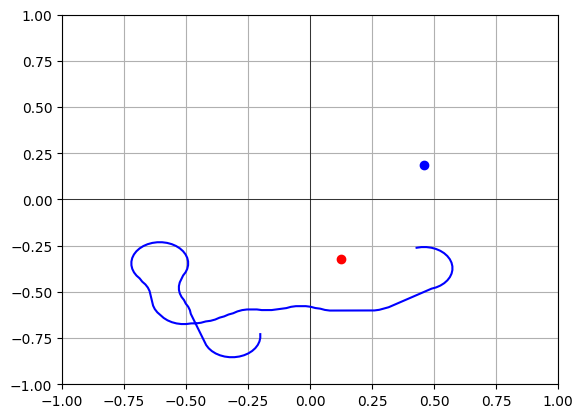

Logging to ./dqn_missile_guidance_local_v2\DQN_0


c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.out_of_bounds to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.out_of_bounds` for environment variables or `env.get_wrapper_attr('out_of_bounds')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.interceptions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.interceptions` for environment variables or `env.get_wrapper_attr('interceptions')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.reached_max_steps to get variables from other wrappers is deprecated and will be 

OUT OF BOUNDS
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 63.1     |
|    ep_rew_mean      | 921      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10988    |
|    fps              | 313      |
|    time_elapsed     | 0        |
|    total_timesteps  | 900173   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 47.6     |
|    n_updates        | 225018   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 63.5     |
|    ep_rew_mean      | 945      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10992    |
|    fps              | 499      |
|    time_elapsed     | 0        |
|    total_timesteps  | 900428   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.28     |
|    n

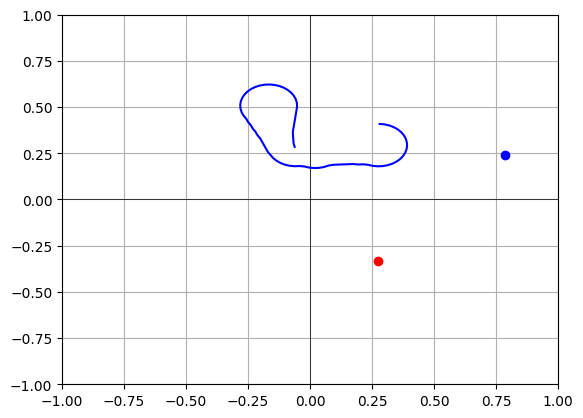

c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.out_of_bounds to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.out_of_bounds` for environment variables or `env.get_wrapper_attr('out_of_bounds')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.interceptions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.interceptions` for environment variables or `env.get_wrapper_attr('interceptions')` that will search the reminding wrappers.
  logger.warn(
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.reached_max_steps to get variables from other wrappers is deprecated and will be 

In [8]:
# ---------------------------------------------------------------------------------------------------------------------------------------------------------
# .........................................................................................................................................................
# ---------------------------------------------------------------------------------------------------------------------------------------------------------
# COPY OF THE CODE ABOVE: THIS VERSION IS FOR TESTING THE ANIMATION FUNCTION 

from copy import deepcopy

log_number = 1

def run_episode(env, model):
    # If you have only one environment wrapped, you can directly access it
    single_env = env.envs[0]
    obs = env.reset()
    done = False
    animate = False
    total_reward = 0
    step = 0
    episode_data = None
    global log_number

    print("EPISODE NUMBER:", log_number)

    episode_data = {
    'past_defense_positions': [], # In upgraded code, we'd only need defense_positions, this is slop, let it work for now
    'attack_positions': [],
    'defense_positions': [], # because you're basically storing the same data in two different places
    }

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        episode_data['past_defense_positions'].append(deepcopy(np.array([obs[0][2], obs[0][3]])))
        obs, reward, done, info = env.step(action)
        episode_data['attack_positions'].append(deepcopy(np.array([obs[0][2], obs[0][3]])))
        episode_data['defense_positions'].append(deepcopy(np.array([obs[0][0], obs[0][1]])))
        total_reward += reward
        step += 1

    print("SE ACABÓ ESTA MONDÁ")
    print("EPISODE COUNT", log_number)
    log_number += 1
    print("EPISODE COUNT AFTER", log_number)
    
    if episode_data is not None:
        print("INSIDE HERE -------------")
        episode_file_name = f'episode_{log_number}_v2_dqn.gif'
        animate_episode(episode_data, episode_file_name)

    # Now access the specific attributes from the single_env which is your actual missile_interception instance
    return step, total_reward, single_env.out_of_bounds, single_env.interceptions, single_env.reached_max_steps

# Create the environment
env = make_vec_env(lambda: missile_interception(), n_envs=1)

# Create the model
model = DQN("MlpPolicy", env, verbose=1, tensorboard_log="./dqn_missile_guidance_local_v2")

# Create a summary writer
summary_writer = tf.summary.create_file_writer('./dqn_missile_guidance_local_v2/custom_metrics')

# Training loop
total_timesteps = 1000000
eval_interval = 100000  # Evaluate and log every 10000 steps

for step in range(0, total_timesteps, eval_interval):
    # Train for a number of timesteps
    model.learn(total_timesteps=eval_interval, reset_num_timesteps=False)
    
    # Run an evaluation episode
    episode_length, episode_reward, out_of_bounds, interceptions, reached_max_steps = run_episode(env, model)
    
    # Log the results
    with summary_writer.as_default():
        tf.summary.scalar('Evaluation/Episode Length', episode_length, step=step)
        # Ensure episode_reward and other metrics are scalars by using .item() if they are numpy arrays or tensors
        tf.summary.scalar('Evaluation/Episode Reward', episode_reward.item() if isinstance(episode_reward, np.ndarray) else episode_reward, step=step)
        tf.summary.scalar('Evaluation/Out of Bounds Count', out_of_bounds.item() if isinstance(out_of_bounds, np.ndarray) else out_of_bounds, step=step)
        tf.summary.scalar('Evaluation/Interceptions Count', interceptions.item() if isinstance(interceptions, np.ndarray) else interceptions, step=step)
        tf.summary.scalar('Evaluation/Reached Max Steps Count', reached_max_steps.item() if isinstance(reached_max_steps, np.ndarray) else reached_max_steps, step=step)
        summary_writer.flush()


# Save the final model
model.save("dqn_missile_guidance_v2")